# 한국 음식 사진 분류

한국에 존재하는 다양한 음식 사진들을 CNN(합성곱 신경망)을 이용하여 분류해 볼 것 입니다

# 환경 세팅

먼저 colab을 본인의 구글 드라이브와 연동시킵니다

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


코드와 데이터가 들어 있는 폴더가 '내 드라이브'에 잘 업로드에 되어 있다면, 다음을 실행합니다

In [ ]:
cd /content/drive/My\ Drive/NIADCC/DCC_1120

/content/drive/My Drive/NIADCC/DCC_1120


런타임 설정</br>

런타임 -> 런타임 유형 변경 -> 하드웨어 가속기 : GPU</br>

할당된 GPU를 확인합니다

In [ ]:
import torch

print('CUDA GPU availalbe : {}'.format(torch.cuda.is_available()))
try:
    print('{} GPU(s) is(are) allocated'.format(torch.cuda.device_count()))
except:
    print('GPUs are not allocated. Current runtime is on CPU.')

CUDA GPU availalbe : True
1 GPU(s) is(are) allocated


# Utility 함수

모델 학습에 관련된 여러 변수들을 다루기 위해 AttributeDict, ConfigTree 객체를 사용할 것입니다

In [ ]:
class AttributeDict(dict):
    def __init__(self):
        self.__dict__ = self
        

class ConfigTree:
    def __init__(self):
        self.DATASET = AttributeDict()
        self.TRAIN = AttributeDict()
        self.MODEL = AttributeDict()
        self.SYSTEM = AttributeDict()

학습시 학습 진행 상황을 모니터링 하기 위해 loss/accuracy 등을 보여주는 logging에 사용될 객체들입니다.</br>

AvgMeter : 현재 iteration에서 지정된 값의 평균을 저장하고 있습니다</br>
get_lr : 현재 학습 step 에서 모델의 learning rate

In [ ]:
import torch
from collections import deque, defaultdict
import os
from datetime import timedelta


class AvgMeter:
    def __init__(self, name="Metric"):
        self.name = name
        self.reset()

    def reset(self):
        self.avg, self.sum, self.count = [0] * 3

    def update(self, val, count=1):
        self.count += count
        self.sum += val * count
        self.avg = self.sum / self.count

    def __repr__(self):
        text = f"{self.name}: {self.avg:.4f}"
        return text


def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group["lr"]

학습 완료 및 학습 중간에 학습된 model의 parameter들을 저장할 겁니다.</br>

save_model : model의 state dict / optimizer의 state dict / 현재 epoch 및 step을 .pth 형태의 파일로</br>
             지정된 디렉토리에 저장

In [ ]:
def save_model(model, optimizer, epoch, step, cfg, val_acc):
    if not os.path.exists(cfg.BASE_SAVE_DIR):
        os.mkdir(cfg.BASE_SAVE_DIR)
        
    if not os.path.exists(cfg.SAVE_DIR):
        os.mkdir(cfg.SAVE_DIR)
    
    file_name = 'best_{}_{}.pth'.format(cfg.MODEL.ARCH, cfg.TEAM_NAME)
    file_path = os.path.join(cfg.SAVE_DIR, file_name)
    torch.save({
            "model" : model.state_dict(),
            "opt" : optimizer.state_dict(),
            "step" : step, 
            "epoch" : epoch, 
            "val acc" : val_acc,
            "config" : cfg
        }, file_path)
    
    return file_path

# 데이터셋 및 데이터 로더

학습에 사용될 이미지들은 jpg 형태로 저장되어 있습니다.</br>
학습에 사용되려면 tensor 형태의 타입으로 변형되어야 하며, 성능 증가를 위해 여러가지 transformation이 가해집니다.</br>
transformation이 지정되면, Dataset 타입으로 학습에 사용될 이미지들을 다루게 되며,</br>
DataLoader 타입의 객체가 매 iteration마다 지정된 수의 이미지들을 GPU에 로딩하게 됩니다.</br>


get_dataset : 데이터셋의 디렉토리 위치와 transform을 지정하면 Dataset 객체를 return</br>
get_loader : 학습 configuration관 Dataset 객체를 지정하면 DataLoader 객체를 return</br>
get_transform : 데이터에 가해지는 transformation을 지정</br>

* loading시 batch size라던가 shuffle 방식, 사용되는 transformation은 자유롭게 변형해도 됩니다.

In [ ]:
from torch.utils.data import DataLoader
from torchvision import transforms, datasets
import numpy as np
from PIL import Image
import json
from glob import glob
import os
from pathlib import Path


"""
BoiledDown : 조림
Kimchi : 김치
Noodle : 면
Rice : 밥
Roasted : 구이
"""


def get_dataset(root, config, transform, mode='train'):
    root = os.path.join(root, mode)
    size = config.TRAIN.AUGMENTATION['size']
    
    if (mode == 'test') or (mode == 'val'):
      normalize = transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
      transform_test = transforms.Compose(
          [
          transforms.Resize(size),
          transforms.CenterCrop(size),
          transforms.ToTensor(),
          normalize
          ]
      )
      return datasets.ImageFolder(root=root, transform=transform_test)
      
    return datasets.ImageFolder(root=root, transform=transform)


def get_loader(dataset, cfg, shuffle=True):
    return DataLoader(dataset, batch_size=cfg.TRAIN.BATCH_SIZE, shuffle=shuffle)


def get_transform(size=224, random_crop=True, use_flip=True, use_color_jitter=False, use_gray_scale=False, use_normalize=False):
    if random_crop:
        resize_crop = transforms.RandomResizedCrop(size=size)
    else:
        resize_crop = transforms.Compose([transforms.Resize(size), transforms.CenterCrop(size)])
    random_flip = transforms.RandomHorizontalFlip(p=0.5)
    color_jitter = transforms.RandomApply([
        transforms.ColorJitter(0.8, 0.8, 0.8, 0.2)
       
    ], p=0.8)
    gray_scale = transforms.RandomGrayscale(p=0.2)
    normalize = transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
    to_tensor = transforms.ToTensor()
    
    transforms_array = np.array([resize_crop, random_flip, color_jitter, gray_scale, to_tensor, normalize])
    transforms_mask = np.array([True, use_flip, use_color_jitter, use_gray_scale, True, use_normalize])
    
    transform = transforms.Compose(transforms_array[transforms_mask])
    
    return transform

## 데이터 예시

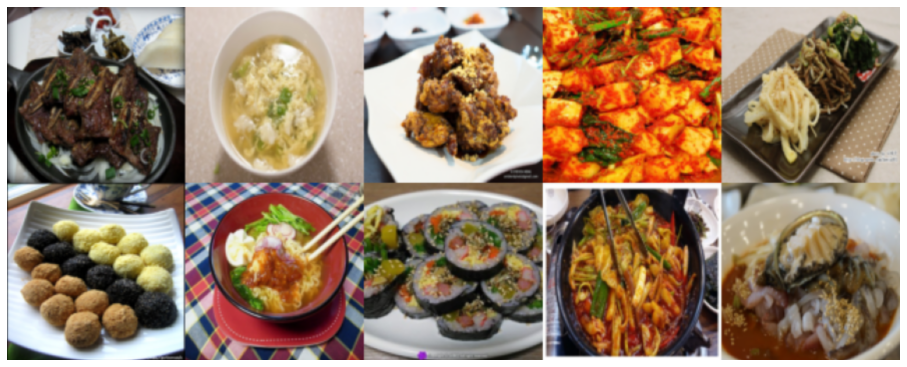

In [ ]:
import matplotlib.pyplot as plt
plt.figure(figsize=(16, 8))
plt.imshow(plt.imread('sample.png'))
plt.axis('off')
plt.show()

한국 음식 종류는 다음과 같이 폴더명과 동일한 label로 분류 되어 있습니다.</br>

Roasted (구이) / Kimchi (김치) / Noodle 면 요리) / Rice (밥 요리) / BoiledDown (조림) 

## 데이터 transformation 예시

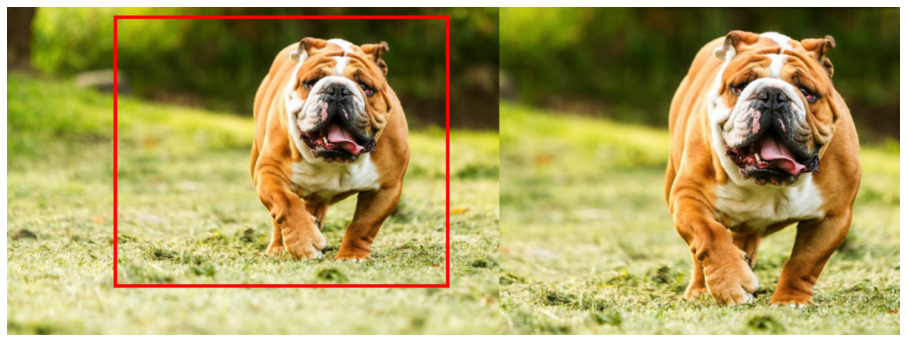

In [ ]:
import matplotlib.pyplot as plt
plt.figure(figsize=(16, 8))
plt.imshow(plt.imread('crop.png'))
plt.axis('off')
plt.show()

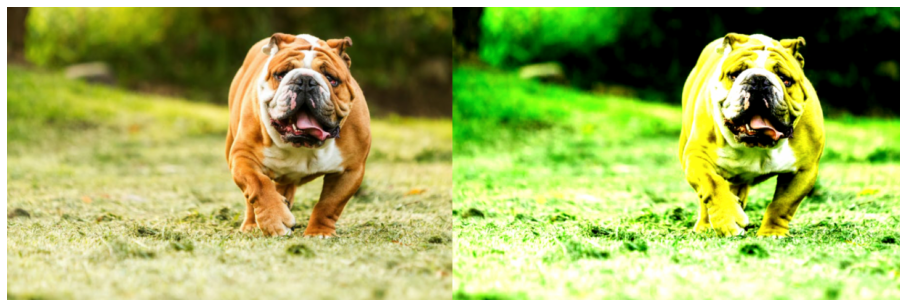

In [ ]:
import matplotlib.pyplot as plt
plt.figure(figsize=(16, 8))
plt.imshow(plt.imread('jitter.png'))
plt.axis('off')
plt.show()

# ConvNet 모델 정의

computer vision 분야에서 feature extraction을 위해 주로 사용되는 합성곱 신경망(CNN)을 사용할 것입니다.</br>
CNN은 convolution 연산을 사용하는 neural network의 종류이며 이를 기반으로 한 다양한 model 구조가 연구되어 있습니다.</br>
본 문제에서는 기본적으로 torchvision.models에 구현되어 있는 model을 사용하는 것으로 구현이 되있습니다.</br>

* ResNet, VGG, AlexNet, Inception 등등 다양한 모델 구조가 있습니다.
* 모델에 따라서 파라미터 수가 다르기도 하고, reasoning을 하는 방식이 다른데
* 무조건 모델이 크다고 해서 성능이 잘 나오는 것은 아니니 여러 실험을 통해 최적의 모델을 학습시키기 바랍니다
* 다른 모델을 구현하거나 가져와서 사용하는 것은 자유입니다. 

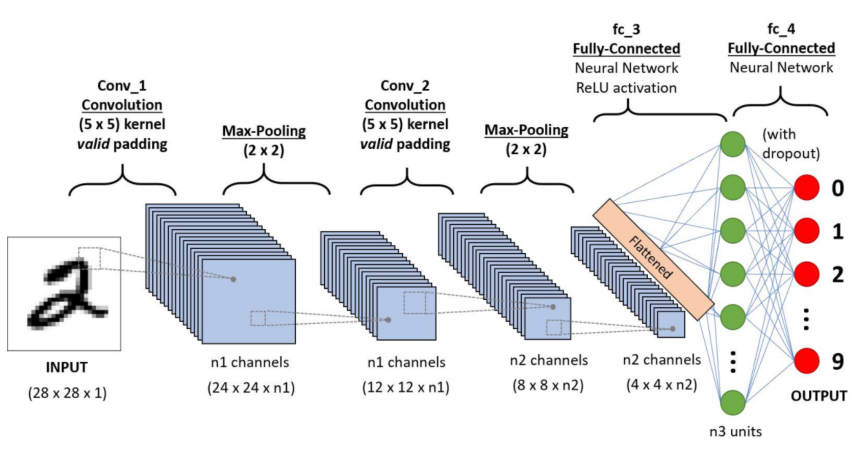

In [ ]:
import matplotlib.pyplot as plt
plt.figure(figsize=(16, 8))
plt.imshow(plt.imread('cnn.png'))
plt.axis('off')
plt.show()

CNN model 불러오기</br>

* torchvision.models에 구현되어 있는 model 구조를 불러오는 경우 이 코드를 사용할 수 있습니다.
* pre-trained model 사용 X 

In [ ]:
import torchvision 
from torchvision import models
import torch.nn as nn


def get_convnet(model_arch='vgg11', pretrain=False, num_classes=5):
    """
    model_arch : torchvision.models에 미리 정의 되어 있는 model을 지정
        예 : 'vgg11', 'vgg11_bn', 'vgg_13', 'vgg_13_bn'
    """
    model = models.__dict__[model_arch](pretrained=pretrain)
    if model_arch.startswith('alexnet'):
        feature_dim = model.classifier[-1].weight.shape[-1]
        model.classifier[-1] = nn.Linear(feature_dim, num_classes)
    elif model_arch.startswith('vgg'):
        feature_dim = model.classifier[-1].weight.shape[-1]
        model.classifier[-1] = nn.Linear(feature_dim, num_classes)
    elif model_arch.startswith('googlenet'):
        feature_dim = model.fc.weight.shape[-1]
        model.fc = nn.Linear(feature_dim, num_classes)
    elif model_arch.startswith('inception'):
        feature_dim = model.fc.weight.shape[-1]
        model.fc = nn.Linear(feature_dim, num_classes)
    elif model_arch.startswith('resnet'):
        feature_dim = model.fc.weight.shape[-1]
        model.fc = nn.Linear(feature_dim, num_classes)
    elif model_arch.startswith('densenet'):
        feature_dim = model.classifier.weight.shape[-1]
        model.classifier = nn.Linear(feature_dim, num_classes)
    elif model_arch.startswith('efficientnet'):
        feature_dim = model.classifier[-1].weight.shape[-1]
        model.classifier[-1] = nn.Linear(feature_dim, num_classes)
    
    return model
    

# Trainer 객체

model, optimizer, 학습 configuration 등을 지정하면 지정된 epoch 동안 학습을 진행하며</br>
학습 진행 상황 (loss, acc)를 output cell에 보여주는 역할을 합니다.

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from datetime import timedelta
# import time
# from tqdm.notebook import tqdm
from tqdm import tqdm


class Trainer:
    def __init__(self, model, optimizer, cfg, device, train_loader, val_loader=None):
        self.cfg = cfg
        self.device = device
        self.train_loader = train_loader
        self.val_loader = val_loader
        print("using gpu {}".format(cfg.SYSTEM.GPU))
        
        self.model = model.to(device)
        
        update_params = [p for p in self.model.parameters() if p.requires_grad]
        self.optimizer = optimizer(update_params, lr=cfg.TRAIN.BASE_LR, weight_decay=cfg.TRAIN.WEIGHT_DECAY)
        self.criterion = nn.CrossEntropyLoss().cuda()
        self.total_step = 0
        self.best_acc = 0
        self.scheduler = None
        
        print(model)
        print()
        print(optimizer)
        print()
               
    def train(self):
        print("training start!\n")
        
        for epoch in range(self.cfg.TRAIN.EPOCH):
            self.train_one_epoch(epoch)
            with torch.no_grad():
                self.validate(epoch)
        
    def train_one_epoch(self, epoch):
        self.model.train()
        tqdm_object = tqdm(self.train_loader, total=len(self.train_loader))
        loss_meter = AvgMeter()
        acc_meter = AvgMeter()
        
        for images, labels in tqdm_object:
            images = images.cuda()
            labels = labels.cuda()
            
            logits = self.model(images)
            loss = self.criterion(logits, labels) 
            
            self.optimizer.zero_grad()
            loss.backward()
            self.optimizer.step()
            
            self.total_step += 1
            
            count = images.shape[0]
            acc = logits.argmax(-1).eq_(labels).float().mean() * 100
            loss_meter.update(loss.detach().cpu().item(), count)
            acc_meter.update(acc.detach().cpu().item(), count) 
            tqdm_object.set_postfix(train_acc=acc_meter.avg, train_loss=loss_meter.avg, lr=get_lr(self.optimizer))

        
    def validate(self, epoch):
        self.model.eval()
        corrects = 0.
        num_data = len(self.val_loader.dataset)
        tqdm_object = tqdm(self.val_loader, total=len(self.val_loader))
        acc_meter = AvgMeter()

        for images, labels in tqdm(self.val_loader):
            images = images.cuda()
            labels = labels.cuda()
            logits = self.model(images)

            count = images.shape[0]
            acc = logits.argmax(-1).eq(labels).float().mean() * 100.
            acc_meter.update(acc.item(), count)
            corrects += logits.argmax(-1).eq(labels).float().sum()

            tqdm_object.set_postfix(val_acc=acc_meter.avg)

        val_acc = (corrects.cpu().item() / num_data) * 100.
        if epoch == 0:
            self.best_acc = val_acc
            saved_path = save_model(self.model, self.optimizer, epoch, self.total_step, self.cfg, val_acc)    
            print('\n epoch = {} step = {} | best model saved : {}\n'.format(epoch, self.total_step, saved_path))   
          
        if val_acc > self.best_acc:
            self.best_acc = val_acc
            saved_path = save_model(self.model, self.optimizer, epoch, self.total_step, self.cfg, val_acc)    
            print('\n epoch = {} step = {} | best model saved : {}\n'.format(epoch, self.total_step, saved_path))   

# 학습 configuration

학습이 의존하는 여러 변인들을 지정하는 객체입니다.</br>
데이터셋 위치, print 주기, 학습 시간, model 구조 등을 이 객체를 통해 변경할 수 있습니다.</br>

* team name을 꼭 기입하시기 바랍니다

In [ ]:
config = ConfigTree()

config.DATASET.ROOT = "./kfood (1)" # 데이터 위치
config.DATASET.NUM_CLASSES = 5 # 분류해야 하는 클래스 종류의 수 

config.BASE_SAVE_DIR = './outputs' # 모델 파라미터가 저장되는 위치

config.SYSTEM.GPU = 0 # GPU 번호 
config.SYSTEM.PRINT_FREQ = 5 # 로그를 프린트하는 주기

# 실험 요소
config.TRAIN.EPOCH = 10 # 총 학습 에폭
config.TRAIN.BATCH_SIZE = 64 # 배치 사이즈
config.TRAIN.BASE_LR = 0.01 # 러닝 레이트
config.TRAIN.AUGMENTATION = {'size' : 224, 'random_crop' : True, 'use_flip' : False, 'use_color_jitter' : False, 'use_gray_scale' : False, 'use_normalize' : True} # 사용할 augmentation
config.TRAIN.WEIGHT_DECAY = 1e-2 # 모델 파라미터 제약


 # 모델 구조
config.MODEL.ARCH = 'vgg16'
config.MODEL.OPTIM = 'SGD' # 파리미터 업데이터(optimizer) 
config.MODEL.PRETRAIN = True

config.TEAM_NAME = 'databus' # 소속 팀 이름(띄어쓰기 없이 영어 알파벳으로만 구성되게 작성)

# main : 학습 실행

In [ ]:
from datetime import datetime

date = datetime.now()
folder_name = '{}_{}_{}_{}'.format(date.month, date.day, date.hour, date.minute)

config.SAVE_DIR = os.path.join(config.BASE_SAVE_DIR, folder_name)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
data_root = config.DATASET.ROOT

transform = get_transform(**config.TRAIN.AUGMENTATION)
train_dataset = get_dataset(data_root, config, transform, 'train')
train_loader = get_loader(train_dataset, config)
val_dataset = get_dataset(data_root, config, transform, 'val')
val_loader = get_loader(val_dataset, config)

model = get_convnet(config.MODEL.ARCH, config.MODEL.PRETRAIN, num_classes=config.DATASET.NUM_CLASSES)
optimizer = optim.__dict__[config.MODEL.OPTIM]

trainer = Trainer(model, optimizer, config, device, train_loader, val_loader)
trainer.train()

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth


  0%|          | 0.00/528M [00:00<?, ?B/s]

using gpu 0
VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0

  0%|          | 0/11 [00:17<?, ?it/s, val_acc=59.6]



 epoch = 0 step = 55 | best model saved : ./outputs/11_20_8_2/best_vgg16_databus.pth



  0%|          | 0/11 [00:17<?, ?it/s, val_acc=81.3]



 epoch = 1 step = 110 | best model saved : ./outputs/11_20_8_2/best_vgg16_databus.pth



  0%|          | 0/11 [00:17<?, ?it/s, val_acc=87.9]



 epoch = 3 step = 220 | best model saved : ./outputs/11_20_8_2/best_vgg16_databus.pth



  0%|          | 0/11 [00:17<?, ?it/s, val_acc=88.6]



 epoch = 4 step = 275 | best model saved : ./outputs/11_20_8_2/best_vgg16_databus.pth



  0%|          | 0/11 [00:17<?, ?it/s, val_acc=91.1]



 epoch = 7 step = 440 | best model saved : ./outputs/11_20_8_2/best_vgg16_databus.pth



  0%|          | 0/11 [00:14<?, ?it/s, val_acc=88.5]


# 학습된 모델 성능 및 config 확인

In [ ]:
exp_time = '11_20_8_2'
model_path = glob('./outputs/{}/best*.pth'.format(exp_time))[0]
ckpt = torch.load(model_path)

trained_config = ckpt['config']
trained_acc = ckpt['val acc']

In [ ]:
print(trained_config.TRAIN)
print(trained_config.MODEL)
print(trained_acc)

{'EPOCH': 10, 'BATCH_SIZE': 64, 'BASE_LR': 0.01, 'AUGMENTATION': {'size': 224, 'random_crop': True, 'use_flip': False, 'use_color_jitter': False, 'use_gray_scale': False, 'use_normalize': True}, 'WEIGHT_DECAY': 0.01}
{'ARCH': 'vgg16', 'OPTIM': 'SGD', 'PRETRAIN': True}
91.08187134502924


# 제출

최종 학습된 model의 checkpoint를 제출합니다. </br>
위에서 학습된 모델들의 성능을 확인하고 제출할 모델을 선택합니다

In [ ]:
submit_exp_time = '11_20_8_2'
submit_model_path = glob('./outputs/{}/best*.pth'.format(submit_exp_time))[0]
submit_ckpt = torch.load(model_path)
submit_config = submit_ckpt['config']
submit_state_dict = submit_ckpt['model']

submit_model = get_convnet(submit_config.MODEL.ARCH, num_classes=5)
submit_model.load_state_dict(submit_state_dict)

<All keys matched successfully>

In [ ]:
import pandas as pd
import numpy as np

test_dataset = get_dataset(root='./kfood (1)/', config=trained_config, transform=None, mode='test')
test_names = list(map(lambda x : os.path.basename(x), list(np.array(test_dataset.imgs)[:, 0])))
test_loader = get_loader(test_dataset, submit_config, shuffle=False)

submit_model.eval()
pred = []
with torch.no_grad():
    for img, _ in tqdm(test_loader):
        logit = submit_model(img.cuda())
        pred.append(logit.argmax(-1).detach().cpu())
    pred = torch.cat(pred).numpy()

100%|██████████| 15/15 [00:20<00:00,  1.34s/it]


In [ ]:
submission = pd.DataFrame({'img' : test_names, 'label' : pred})
submission.to_csv('submission_{}.csv'.format(submit_config.TEAM_NAME), index=False)